In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import s3fs
import warnings
warnings.filterwarnings('ignore')

In [2]:
# df = pd.read_parquet("../data/Silver/eda_cleaned_HI-Medium_Trans.parquet")
df = pd.read_parquet("s3://bass-risk-monitoring/Silver/eda_cleaned_HI-Medium_Trans.parquet")

In [3]:
df.shape

(31898238, 19)

In [4]:
df.dtypes

Timestamp              datetime64[ns]
From Bank                       int32
Account                string[python]
To Bank                         int32
Account.1              string[python]
Amount Received               float64
Receiving Currency           category
Amount Paid                   float64
Payment Currency             category
Payment Format               category
Is Laundering                    int8
log_amount_paid               float64
log_amount_received           float64
hour                            int32
date                           object
month                       period[M]
day_of_week                     int32
is_weekend                      int64
daily_txn_count                 int64
dtype: object

In [5]:
df.columns  

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering',
       'log_amount_paid', 'log_amount_received', 'hour', 'date', 'month',
       'day_of_week', 'is_weekend', 'daily_txn_count'],
      dtype='object')

### Feature engineering

Temporal Feature Engineering

In [6]:
df = df.sort_values(['Account', 'Timestamp']).reset_index(drop=True)

# Night activity (0–6 AM)
df['is_night_txn'] = df['hour'].between(0, 6).astype(int)
# Business day (Mon–Fri)
df['is_business_day'] = df['day_of_week'].between(0, 4).astype(int)

In [7]:
# time since last txn (sec) per account

df['time_since_last_txn'] = (
    df.groupby('Account')['Timestamp']
      .diff()
      .dt.total_seconds()
      .fillna(0)
)


In [8]:
# Rolling 24h transaction count per account
df['_ones'] = 1
temp = (
    df.set_index('Timestamp')
      .groupby('Account')['_ones']
      .rolling('1D')
      .sum()
      .astype('int32')
      .reset_index(level=0, drop=True)
)

df = df.set_index('Timestamp')
df['txn_count_24h'] = temp
df = df.reset_index()

df['txn_count_24h_excl'] = (df['txn_count_24h'] - 1).astype('int32')
df.drop(columns=['_ones'], inplace=True, errors='ignore')



In [9]:
# Rolling 7-day average using transform

df['rolling_avg_paid_7d'] = (
    df.groupby('Account')
      .rolling('7D', on='Timestamp')['Amount Paid']
      .mean()
      .reset_index(drop=True)
      .fillna(0)
)


In [10]:
# Aggregate time gap stats per account (safe version)
df['avg_txn_gap'] = df.groupby('Account')['time_since_last_txn'].transform('mean')
df['std_txn_gap'] = df.groupby('Account')['time_since_last_txn'].transform('std')
 

In [11]:
# Week number and monthly transaction count
df['week'] = df['Timestamp'].dt.isocalendar().week
df['monthly_txn_count'] = df.groupby(['Account', df['Timestamp'].dt.month])['Amount Paid'].transform('count')


In [12]:
print("After temporal feats:", df.shape)


After temporal feats: (31898238, 29)


Behavioral Feature Engineering

In [13]:
# Amount ratio and log ratio
df['amount_ratio'] = df['Amount Paid'] / (df['Amount Received'] + 1e-6)
df['log_amount_ratio'] = np.log1p(df['amount_ratio'])

In [14]:
# Diversity features
df['currency_diversity'] = df.groupby('Account')['Payment Currency'].transform('nunique')
df['format_diversity']   = df.groupby('Account')['Payment Format'].transform('nunique')

In [15]:
# Z-score of Amount Paid per account
mean_paid = df.groupby('Account')['Amount Paid'].transform('mean')
std_paid  = df.groupby('Account')['Amount Paid'].transform('std')

df['amount_paid_zscore'] = (df['Amount Paid'] - mean_paid) / (std_paid + 1e-6)


In [16]:
 # rolling 7-day average and std of 'Amount Paid' per account.
def add_rolling_payment_behavior(df, window='7D'):
    df = df.sort_values(['Account', 'Timestamp']).reset_index(drop=True)

    df['rolling_avg_paid_7d'] = (
        df.groupby('Account')
          .rolling(window, on='Timestamp')['Amount Paid']
          .mean()
          .reset_index(drop=True)
          .fillna(0)
    )

    df['rolling_std_paid_7d'] = (
        df.groupby('Account')
          .rolling(window, on='Timestamp')['Amount Paid']
          .std()
          .reset_index(drop=True)
          .fillna(0)
    )

    return df


In [17]:
df = add_rolling_payment_behavior(df, window='7D')

In [18]:

print("After behavioral feats:", df.shape)


After behavioral feats: (31898238, 35)


Network / Relational Feature Engineering

In [19]:
# Unique Receivers per Sender
df['unique_receivers'] = df.groupby('Account')['To Bank'].transform('nunique')

In [20]:
# Unique Senders per Receiver
df['unique_senders'] = df.groupby('Account.1')['From Bank'].transform('nunique')

In [21]:
# Self-Transfer Flag
df['is_self_transfer'] = (df['Account'] == df['Account.1']).astype('int8')


In [22]:
# Transfer direction ratio (outgoing / incoming transactions per account)
sent_counts = df.groupby('Account')['Amount Paid'].transform('count')
recv_counts = df.groupby('Account.1')['Amount Paid'].transform('count')

df['transfer_direction_ratio'] = sent_counts / (recv_counts + 1e-6)


In [23]:
# High-Frequency Receiver
threshold = df['unique_senders'].quantile(0.95)
df['is_high_freq_receiver'] = (df['unique_senders'] > threshold).astype('int8')


In [24]:
print("After network feats:", df.shape)

After network feats: (31898238, 40)


In [25]:
df.dtypes

Timestamp                   datetime64[ns]
From Bank                            int32
Account                     string[python]
To Bank                              int32
Account.1                   string[python]
Amount Received                    float64
Receiving Currency                category
Amount Paid                        float64
Payment Currency                  category
Payment Format                    category
Is Laundering                         int8
log_amount_paid                    float64
log_amount_received                float64
hour                                 int32
date                                object
month                            period[M]
day_of_week                          int32
is_weekend                           int64
daily_txn_count                      int64
is_night_txn                         int64
is_business_day                      int64
time_since_last_txn                float64
txn_count_24h                        int32
txn_count_2

### Feature Selection

Correlation Analysis

In [27]:
numeric_cols = df.select_dtypes(include='number').columns.tolist()


In [29]:
threshold = 0.9
corr_matrix = df[numeric_cols].corr()

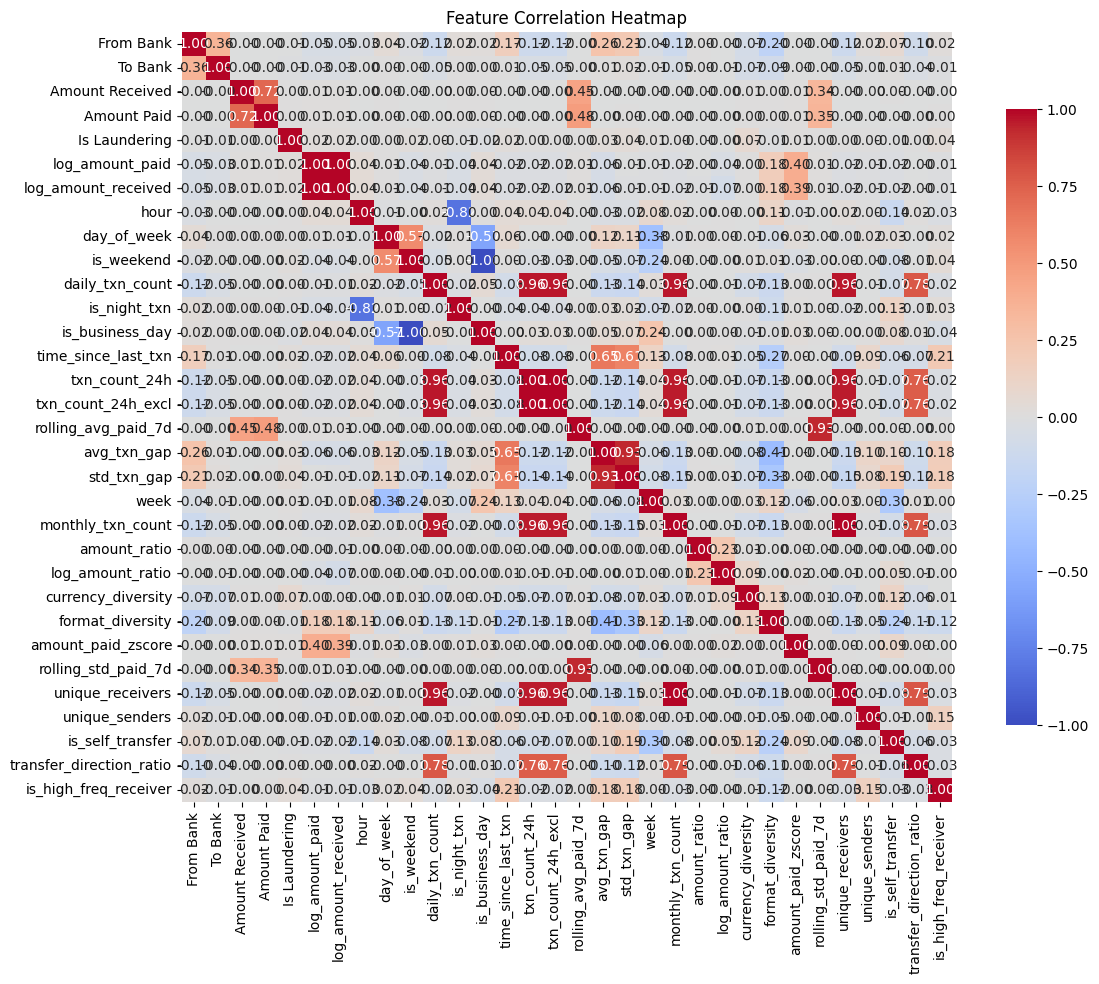

In [30]:
# Correlation
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Feature Correlation Heatmap")
plt.show()

In [34]:
# Upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# highly correlated features
highly_corr = [col for col in upper.columns if any(upper[col].abs() > 0.9)]
print("Highly correlated to drop:", highly_corr)

Highly correlated to drop: ['log_amount_received', 'is_business_day', 'txn_count_24h', 'txn_count_24h_excl', 'std_txn_gap', 'monthly_txn_count', 'rolling_std_paid_7d', 'unique_receivers']


In [39]:
df.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering',
       'log_amount_paid', 'log_amount_received', 'hour', 'date', 'month',
       'day_of_week', 'is_weekend', 'daily_txn_count', 'is_night_txn',
       'is_business_day', 'time_since_last_txn', 'txn_count_24h',
       'txn_count_24h_excl', 'rolling_avg_paid_7d', 'avg_txn_gap',
       'std_txn_gap', 'week', 'monthly_txn_count', 'amount_ratio',
       'log_amount_ratio', 'currency_diversity', 'format_diversity',
       'amount_paid_zscore', 'rolling_std_paid_7d', 'unique_receivers',
       'unique_senders', 'is_self_transfer', 'transfer_direction_ratio',
       'is_high_freq_receiver'],
      dtype='object')

In [35]:
# Protect domain-relevant features
protected = {               
    'txn_count_24h_excl',          
    'rolling_std_paid_7d',        
    'unique_receivers'            
}
to_drop = [f for f in highly_corr if f not in protected]
print("To drop after protection:", to_drop)

To drop after protection: ['log_amount_received', 'is_business_day', 'txn_count_24h', 'std_txn_gap', 'monthly_txn_count']


In [ ]:
df_reduced = df.drop(columns=list(to_drop), errors='ignore')
print(f"Remaining columns: {len(df_reduced.columns)}")
df_reduced.shape

Remaining columns: 35


(31898238, 35)

In [38]:
df_reduced.to_parquet("../data/Silver/df_reduced.parquet", index=False)